In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Peak in sensitivity persists in renewed data - can we get rid of it with alternative starting states?

# Imports

In [ ]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.misc.units import per_mol_to_per_molecule
from synbio_morpher.utils.common.setup import prepare_config, construct_circuit_from_cfg
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.misc.type_handling import flatten_listlike

# jupyter nbconvert --to notebook --execute 25_sensitivity_peak_2.ipynb --output=25_sensitivity_peak_2_1.ipynb --ExecutePreprocessor.timeout=-1



# Analysis of generated data

1. What is the value of the sensitivity peak ($s_{peak}$)?
2. Which circuits get an $s_{peak}$?
3. What does the peak depend on? Could it be...
    - Forward rate
    - Initial state
    - Value of signal input
4. Is there a better way of simulating circuits where some components have no interaction? Can we assign a zero rate in both directions??

## Load data

In [119]:
fn = '../data/ensemble_mutation_effect_analysis/2024_11_11_135219/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,sample_num,name,interacting,...,initial_steady_states,max_amount,min_amount,overshoot,RMSE,steady_states,response_time_wrt_species-6,precision_wrt_species-6,sensitivity_wrt_species-6,sample_name
0,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,400.0,199.73235,0.802002,0.000000,399.19800,0.0,1.004021,1.000000,RNA_0
1,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
2,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_2
3,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,400.0,199.73235,0.802002,0.000000,399.19800,0.0,1.004021,1.000000,RNA_0
4,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,toy_mRNA_circuit_99,RNA_2_m1-0,1,[8],[9],./data/ensemble_mutation_effect_analysis/2024_...,4.0,9.0,toy_mRNA_circuit_99,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
6296,toy_mRNA_circuit_99,RNA_2_m1-0,1,[8],[9],./data/ensemble_mutation_effect_analysis/2024_...,4.0,9.0,toy_mRNA_circuit_99,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_2
6297,toy_mRNA_circuit_99,RNA_2_m1-1,1,[2],[14],./data/ensemble_mutation_effect_analysis/2024_...,5.0,9.0,toy_mRNA_circuit_99,[[1 2]],...,199.74307,400.0,199.74307,0.780518,0.021447,399.21948,0.0,1.003913,1.000000,RNA_0
6298,toy_mRNA_circuit_99,RNA_2_m1-1,1,[2],[14],./data/ensemble_mutation_effect_analysis/2024_...,5.0,9.0,toy_mRNA_circuit_99,[[1 2]],...,192.17154,200.0,192.11177,0.000000,7.546352,192.11177,0.0,3223.526400,0.000310,RNA_1


## Value of sensitivity peak

The sensitivity peak is at 0.00033288274


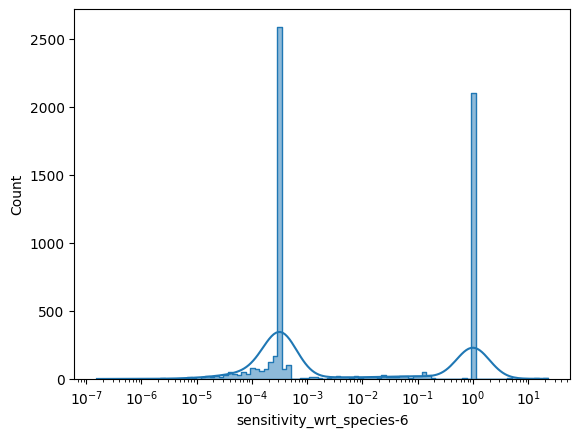

In [120]:
sns.histplot(data, x='sensitivity_wrt_species-6', bins=100, element='step', log_scale=[True, False], kde=True)
s_peak = data['sensitivity_wrt_species-6'].median()
print(f'The sensitivity peak is at {s_peak}')

## Circuits that have the $s_{peak}$

Once again, the circuits at the sensitivity peak are the ones where none of the RNAs are interacting, aka 'null circuits'.

In [121]:
cols_e = get_true_interaction_cols(data, 'energies')
data[data['sensitivity_wrt_species-6'] == s_peak][['circuit_name'] + cols_e].iloc[:5]

,circuit_name,energies_0-0,energies_0-1,energies_0-2,energies_1-0,energies_1-1,energies_1-2,energies_2-0,energies_2-1,energies_2-2
1,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
cols_brd = get_true_interaction_cols(data, 'binding_rates_dissociation')
data[data['sensitivity_wrt_species-6'] == s_peak][['circuit_name'] + cols_brd].iloc[:5]

,circuit_name,binding_rates_dissociation_0-0,binding_rates_dissociation_0-1,binding_rates_dissociation_0-2,binding_rates_dissociation_1-0,binding_rates_dissociation_1-1,binding_rates_dissociation_1-2,binding_rates_dissociation_2-0,binding_rates_dissociation_2-1,binding_rates_dissociation_2-2
1,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
2,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
4,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
5,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
7,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995


# What does the peak depend on?

Let's construct a bunch of null circuits that have different starting states, forward rates, and signal targets.
Forward rates are usually 1e6 per mol, so we can try different rates like 1e3 to 1e10. These have to be converted to per molecule.

In [123]:
config = load_json_as_dict('../synbio_morpher/utils/common/testing/configs/simple_circuit.json')

k_a_og = 0.00150958097
forward_rates = jax.tree_util.tree_map(per_mol_to_per_molecule, jnp.power(10, np.arange(3, 10, 0.5)))
starting_states_all = np.arange(10, 310, 20)
starting_states_all = np.concatenate([starting_states_all[:, None] * np.ones((len(starting_states_all), 3)), np.random.randint(10, 300, (len(starting_states_all), 3))])
signal_targets = np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 4, 0.5), np.arange(4, 8, 1)])

# n_small = 3
# starting_states_all = starting_states_all[:n_small]
# forward_rates = forward_rates[:n_small]
# signal_targets = signal_targets[:n_small]

print(f'There are a total of {len(starting_states_all) * len(forward_rates) * len(signal_targets)} simulations to run')


There are a total of 11340 simulations to run


In [ ]:
config = prepare_config(config)
config['include_prod_deg'] = False
config['simulation']['batch_size'] = 1000
config['simulation']['device'] = 'gpu'
config['simulation']['dt0'] = 0.005
config['simulation']['dt1'] = 0.005 / 2
config['simulation']['t0'] = 0
config['simulation']['t1'] = 10
config['simulation']['tmax'] = 1500
config['simulation']['use_initial_to_add_signal'] = False
config['simulation']['use_rate_scaling'] = True
config['signal']['function_kwargs']['target'] = 2


In [125]:
def load_circuit(k_a, energies, eqconstants, starting_states, signal_target):
    c = {'data_path': data[data['sensitivity_wrt_species-6'] == s_peak]['path_to_template_circuit'].iloc[0].replace('./', '../'),
        #  'molecular_params': config['molecular_params'],
         'signal': config['signal']}
    c['signal']['function_kwargs']['target'] = signal_target
    # c['molecular_params']['starting_copynumbers'] = np.mean(starting_states)
    
    circuit = construct_circuit_from_cfg(c, config)
    circuit.interactions.energies = energies
    circuit.interactions.eqconstants = eqconstants
    circuit.interactions.binding_rates_association = k_a
    circuit.interactions.binding_rates_dissociation = k_a / eqconstants
    if type(starting_states) == np.ndarray:
        for i, (s, r) in enumerate(zip(starting_states, circuit.qreactions.reactants)):
            circuit.qreactions.reactants[i].quantity = s
    return circuit


energies = data[data['sensitivity_wrt_species-6']
                == s_peak][cols_e].iloc[0].values
eqconstants = data[data['sensitivity_wrt_species-6'] ==
                   s_peak][get_true_interaction_cols(data, 'eqconstants')].iloc[0].values
circuits = []
data_circuits = pd.DataFrame(columns=['circuit_name', 'k_a', 'starting_state', 'signal_target', 'circuit'])
for i, (k_a, starting_state, signal_target) in enumerate(itertools.product(forward_rates, starting_states_all, signal_targets)):
    circuit = load_circuit(k_a, energies, eqconstants, starting_state, signal_target)
    name = f'RNA_circuit_{i}'
    circuit.name = name
    data_circuits.loc[i] = [name, k_a, starting_state, signal_target, circuit]
    circuits.append(circuit)

In [126]:
data_circuits

,circuit_name,k_a,starting_state,signal_target,circuit
0,RNA_circuit_0,0.000002,"[10.0, 10.0, 10.0]",0.1,<synbio_morpher.utils.circuit.agnostic_circuit...
1,RNA_circuit_1,0.000002,"[10.0, 10.0, 10.0]",0.2,<synbio_morpher.utils.circuit.agnostic_circuit...
2,RNA_circuit_2,0.000002,"[10.0, 10.0, 10.0]",0.3,<synbio_morpher.utils.circuit.agnostic_circuit...
3,RNA_circuit_3,0.000002,"[10.0, 10.0, 10.0]",0.4,<synbio_morpher.utils.circuit.agnostic_circuit...
4,RNA_circuit_4,0.000002,"[10.0, 10.0, 10.0]",0.5,<synbio_morpher.utils.circuit.agnostic_circuit...
...,...,...,...,...,...
11335,RNA_circuit_11335,4.773714,"[197.0, 98.0, 256.0]",3.5,<synbio_morpher.utils.circuit.agnostic_circuit...
11336,RNA_circuit_11336,4.773714,"[197.0, 98.0, 256.0]",4.0,<synbio_morpher.utils.circuit.agnostic_circuit...
11337,RNA_circuit_11337,4.773714,"[197.0, 98.0, 256.0]",5.0,<synbio_morpher.utils.circuit.agnostic_circuit...
11338,RNA_circuit_11338,4.773714,"[197.0, 98.0, 256.0]",6.0,<synbio_morpher.utils.circuit.agnostic_circuit...


# Run simulation

In [ ]:
run_sim = False

In [ ]:
if run_sim:
    config, result_writer = script_preamble(
        config=config, data_writer=None)
    circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)

In [ ]:
if run_sim:
    new_circuits = []
    bs = config['simulation']['batch_size']
    for i in range(0, len(circuits), bs):
        print(f'step {i}')
        try:
            new_circuits.append(
                circuit_modeller.batch_circuits(
                    circuits=circuits[i:i + bs],
                    batch_size=bs,
                    methods={
                        "compute_interactions": {},
                        "init_circuits": {'batch': True},
                        'simulate_signal_batch': {'ref_circuit': None,
                                                'batch': config['simulation']['use_batch_mutations']},
                        'write_results': {'no_visualisations': False,  # config['experiment']['no_visualisations'],
                                        'no_numerical': False}  # config['experiment']['no_numerical']}
                    }
                )
            )
        except Exception as e:
            print(e)
            print(f'Could not run batch {i} to {i + bs}...')
            print(
                f'Something wrong in {data_circuits.iloc[i:i + bs][["k_a", "starting_state", "signal_target"]]}')
            break
    new_circuits = flatten_listlike(new_circuits)

circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.002637s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_0: compute_interactions WARNING


step 0


circuit_manager.py:run_batch():700: 		Method compute_interactions took 0.545749s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_0: init_circuits WARNING


Done:  0:00:04.383137


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.650632s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_0: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.988021s WARNING


Done:  0:00:01.936655


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 21.981969s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 35.339977s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_0: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 161.373827s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:03:22.917405 
Projected time: 202.714487595s 
Total time: 0:03:22.917427 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.1e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_999: compute_interactions WARNING
circuit_manager.py:run_batch():700: 

Done:  0:00:04.031645


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.729014s WARNING


Done:  0:00:01.717247


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.405771s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 6.630419s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.153849s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:10.860797 
Projected time: 0.010860797s 
Total time: 0:03:38.135924 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001059s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 		R

step 1000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 84.708636s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_1000: init_circuits WARNING


Done:  0:00:03.876620


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.196529s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_1000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.750555s WARNING


Done:  0:00:01.733801


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 21.899525s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 28.329436s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_1000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 161.80129s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:04:40.040713 
Projected time: 279.760672287s 
Total time: 0:04:40.040724 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.2e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_1999: compute_interactions WARNING
circuit_manager.py:run_batch():70

Done:  0:00:03.730942


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.389267s WARNING


Done:  0:00:01.377092


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.406772s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 9.174683s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_1999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.153902s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:13.244451 
Projected time: 0.013244450999999999s 
Total time: 0:05:00.750889 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001064s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch(

step 2000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 120.748424s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_2000: init_circuits WARNING


Done:  0:00:03.933795


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.216518s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_2000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.703738s WARNING


Done:  0:00:01.681619


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 22.259557s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 31.472474s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_2000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 166.928066s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:24.370479 
Projected time: 324.046108521s 
Total time: 0:05:24.370493 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.2e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_2999: compute_interactions WARNING
circuit_manager.py:run_batch():7

Done:  0:00:03.793261


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.413312s WARNING


Done:  0:00:01.400463


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.419541s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 12.23746s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_2999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.162024s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:16.383359 
Projected time: 0.016383359s 
Total time: 0:05:51.224876 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001092s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 		

step 3000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 122.42357s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_3000: init_circuits WARNING


Done:  0:00:03.883604


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.206893s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_3000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.659228s WARNING


Done:  0:00:01.638353


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 21.915354s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 34.140061s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_3000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 170.15646s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:31.932651 
Projected time: 331.60071834900003s 
Total time: 0:05:31.932664 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_3999: compute_interactions WARNING
circuit_manager.py:run_batch()

Done:  0:00:03.755074


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.624295s WARNING


Done:  0:00:01.612026


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.429431s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 15.616871s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_3999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.161561s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:19.714840 
Projected time: 0.019714839999999997s 
Total time: 0:06:05.244751 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001082s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch

step 4000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 119.625873s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_4000: init_circuits WARNING


Done:  0:00:03.896573


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.187639s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_4000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.595278s WARNING


Done:  0:00:01.575243


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 21.83655s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 36.807721s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_4000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 157.441922s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:19.068179 
Projected time: 318.749110821s 
Total time: 0:05:19.068191 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.2e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_4999: compute_interactions WARNING
circuit_manager.py:run_batch():70

Done:  0:00:03.771987


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.461564s WARNING


Done:  0:00:01.449224


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.414184s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 18.548737s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_4999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.164691s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:22.682824 
Projected time: 0.022682824s 
Total time: 0:05:58.184283 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001107s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 	

step 5000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 120.016112s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_5000: init_circuits WARNING


Done:  0:00:03.877282


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.178037s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_5000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.871666s WARNING


Done:  0:00:01.766459


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 22.151647s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 40.752871s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_5000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 157.327204s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:23.279909 
Projected time: 322.95662909099997s 
Total time: 0:05:23.279920 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.1e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_5999: compute_interactions WARNING
circuit_manager.py:run_batc

Done:  0:00:03.734753


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.023533s WARNING


Done:  0:00:01.011503


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.406948s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 21.223539s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_5999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.173978s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:25.318630 
Projected time: 0.025318629999999998s 
Total time: 0:06:08.312354 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.00113s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch(

step 6000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 118.63874s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_6000: init_circuits WARNING


Done:  0:00:03.870684


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.177547s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_6000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.946723s WARNING


Done:  0:00:01.919669


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 21.975001s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 43.53571s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_6000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 157.077294s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:24.435990 
Projected time: 324.11155401s 
Total time: 0:05:24.436004 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.2e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_6999: compute_interactions WARNING
circuit_manager.py:run_batch():700

Done:  0:00:03.760329


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.041055s WARNING


Done:  0:00:01.029076


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.408235s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 24.284364s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_6999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.169275s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:28.407285 
Projected time: 0.028407285s 
Total time: 0:06:15.730115 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001168s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 	

step 7000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 118.197072s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_7000: init_circuits WARNING


Done:  0:00:03.893349


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.156199s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_7000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.965336s WARNING


Done:  0:00:01.944808


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 21.833711s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 46.232588s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_7000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 151.824623s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:21.415632 
Projected time: 321.09421636800005s 
Total time: 0:05:21.415647 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.3e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_7999: compute_interactions WARNING
circuit_manager.py:run_batc

Done:  0:00:03.726681


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.551991s WARNING


Done:  0:00:01.539905


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.406379s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 27.544048s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_7999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.176327s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:31.645997 
Projected time: 0.031645997s 
Total time: 0:06:18.211017 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001026s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 	

step 8000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 118.102251s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_8000: init_circuits WARNING


Done:  0:00:03.876788


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.183243s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_8000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.781877s WARNING


Done:  0:00:01.729573


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 22.083476s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 49.078456s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_8000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 152.161517s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:24.531179 
Projected time: 324.20664782100005s 
Total time: 0:05:24.531191 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.4e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_8999: compute_interactions WARNING
circuit_manager.py:run_batc

Done:  0:00:03.759776


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.737253s WARNING


Done:  0:00:01.725202


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.406951s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 30.4901s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_8999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.167894s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:34.609934 
Projected time: 0.034609934s 
Total time: 0:06:28.157923 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001157s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 		R

step 9000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 118.294706s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_9000: init_circuits WARNING


Done:  0:00:03.882768


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.133642s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_9000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 2.421837s WARNING


Done:  0:00:02.400280


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 21.819016s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 52.821428s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_9000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 151.389703s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:27.644928 
Projected time: 327.317283072s 
Total time: 0:05:27.644939 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 2.3e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_9999: compute_interactions WARNING
circuit_manager.py:run_batch():7

Done:  0:00:03.763522


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.878571s WARNING


Done:  0:00:01.866234


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.412994s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 33.984015s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_9999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.167084s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:38.096693 
Projected time: 0.038096693s 
Total time: 0:06:37.352385 WARNING
circuit_manager.py:batch_circuits():599: 	From 1000 circuits, a total of 1000 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 999 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 999 took 0.001099s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 999 (total: 1000)) (Circuits: 0 - 999 of 1000) WARNING
circuit_manager.py:run_batch():664: 	

step 10000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 118.014923s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_10000: init_circuits WARNING


Done:  0:00:03.877897


circuit_manager.py:run_batch():700: 		Method init_circuits took 5.186816s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_10000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 2.03995s WARNING


Done:  0:00:02.020325


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 22.098757s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 55.56452s WARNING
circuit_manager.py:run_batch():664: 		Running 999 Subcircuits - RNA_circuit_10000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 146.27938s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:05:25.051692 
Projected time: 324.726640308s 
Total time: 0:05:25.051705 WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (999 - 1000 / 1000) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 999 - 1000 took 1.2e-05s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 999 - 1000 (total: 1000)) (Circuits: 999 - 1000 of 1000) WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_10999: compute_interactions WARNING
circuit_manager.py:run_batch():7

Done:  0:00:03.743428


circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.027726s WARNING


Done:  0:00:01.015802


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 0.40401s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 35.808622s WARNING
circuit_manager.py:run_batch():664: 		Running 1 Subcircuits - RNA_circuit_10999: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 0.158113s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:00:39.900584 
Projected time: 0.039900584s 
Total time: 0:06:39.226431 WARNING
circuit_manager.py:batch_circuits():599: 	From 340 circuits, a total of 340 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():606: 		Starting new round of viable circuits (0 - 340 / 340) WARNING
circuit_manager.py:batch_circuits():626: 		Making subcircuits 0 - 340 took 0.000382s WARNING
circuit_manager.py:batch_circuits():632: 	Batching 0 - 1000 circuits (out of 0 - 340 (total: 340)) (Circuits: 0 - 340 of 340) WARNING
circuit_manager.py:run_batch():664: 		Runn

step 11000


circuit_manager.py:run_batch():700: 		Method compute_interactions took 40.390361s WARNING
circuit_manager.py:run_batch():664: 		Running 340 Subcircuits - RNA_circuit_11000: init_circuits WARNING


Done:  0:00:04.405523


circuit_manager.py:run_batch():700: 		Method init_circuits took 4.892113s WARNING
circuit_manager.py:run_batch():664: 		Running 340 Subcircuits - RNA_circuit_11000: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():514: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():355: 		Simulating signal took 1.417683s WARNING


Done:  0:00:01.364261


circuit_manager.py:simulate_signal_batch():413: 		Calculating analytics took 7.721868s WARNING
circuit_manager.py:run_batch():700: 		Method simulate_signal_batch took 44.30032s WARNING
circuit_manager.py:run_batch():664: 		Running 340 Subcircuits - RNA_circuit_11000: write_results WARNING
circuit_manager.py:run_batch():700: 		Method write_results took 49.664675s WARNING
circuit_manager.py:batch_circuits():646: Single batch: 0:02:19.251937 
Projected time: 139.251937s 
Total time: 0:02:19.251953 WARNING


In [ ]:
idxs_output = -1

if run_sim:
    for a in new_circuits[0].result_collector.results['signal'].analytics.keys():
        data_circuits[a] = data_circuits['circuit'].apply(lambda c: c.result_collector.results['signal'].analytics[a][idxs_output] if c.result_collector.results.get('signal') else np.nan)
    result_writer
    data_circuits.drop(columns=['circuit']).to_csv('data_circuits')

/tmp/ipykernel_1967281/3406425449.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


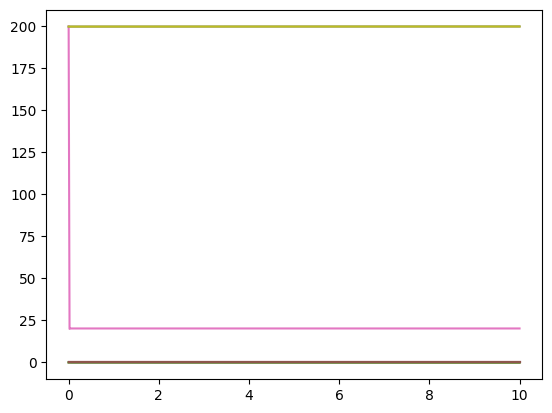

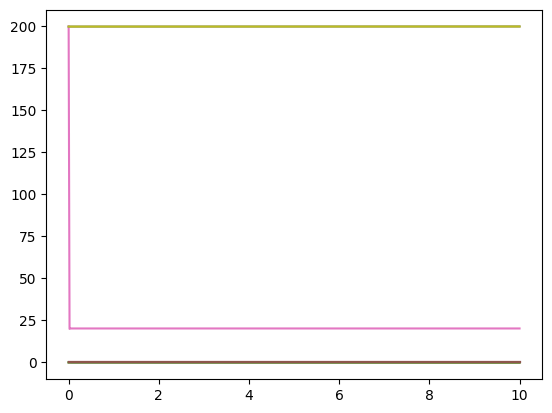

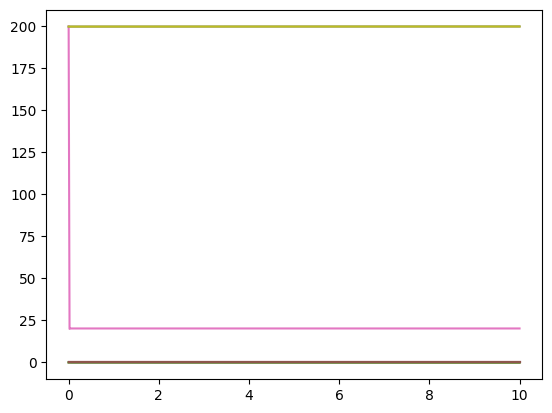

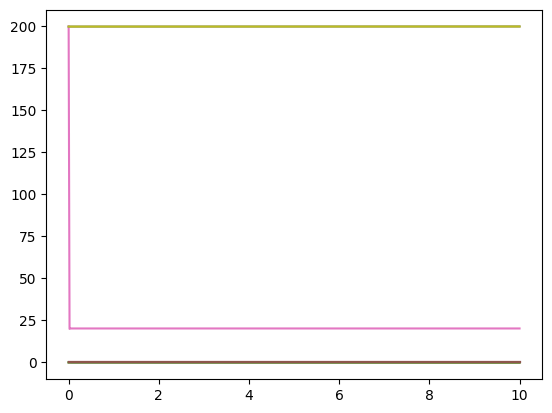

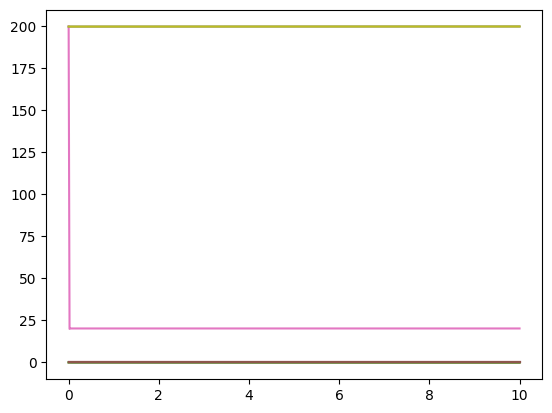

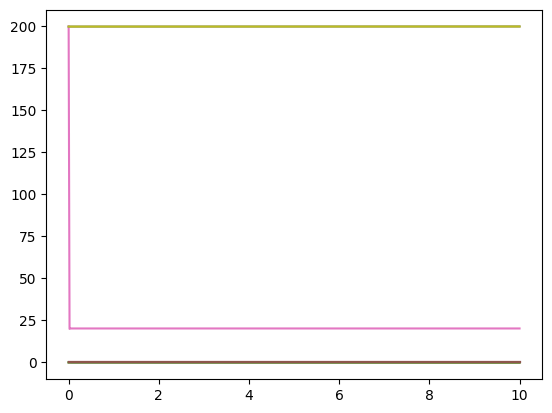

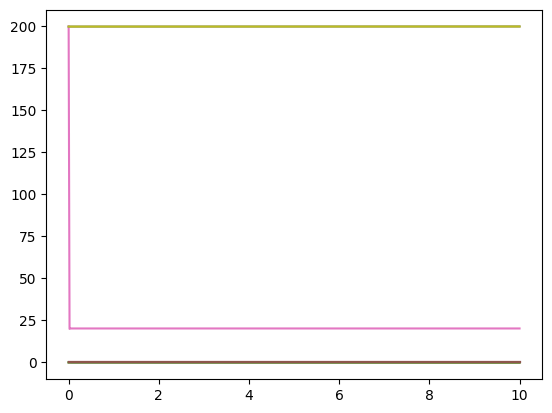

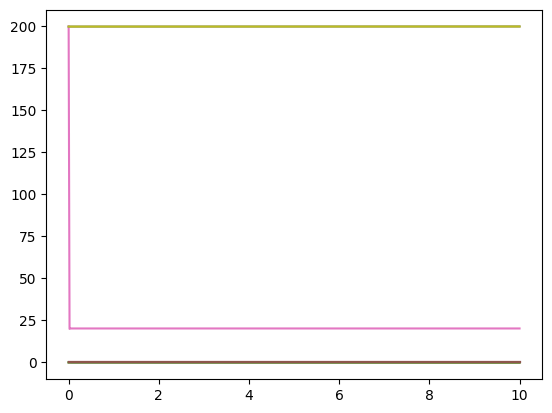

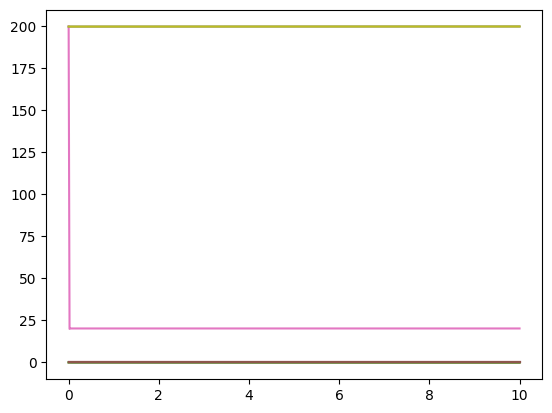

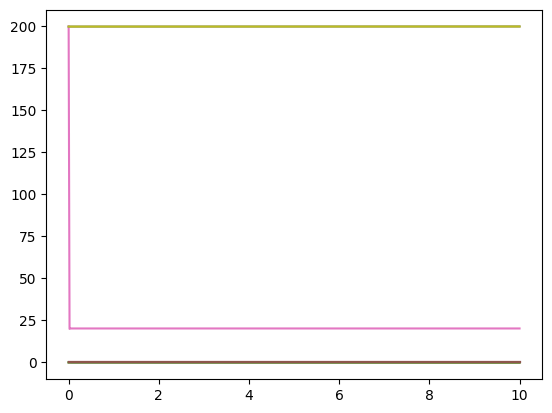

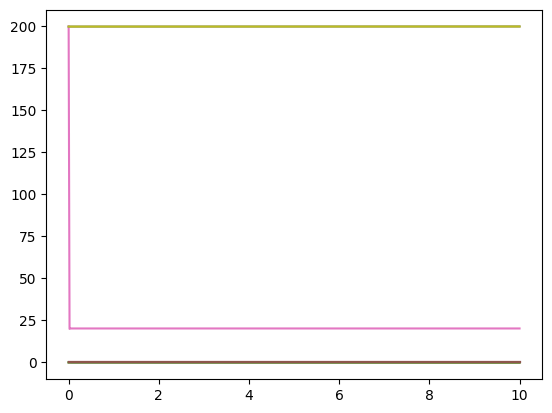

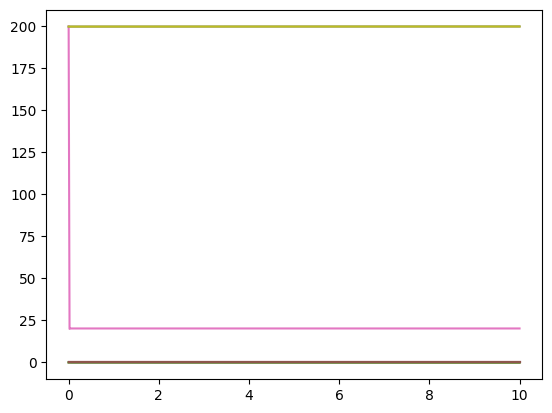

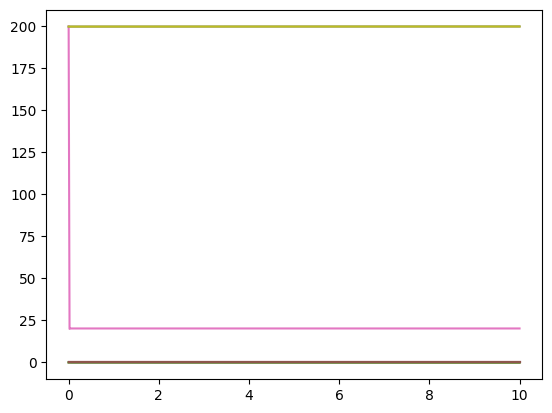

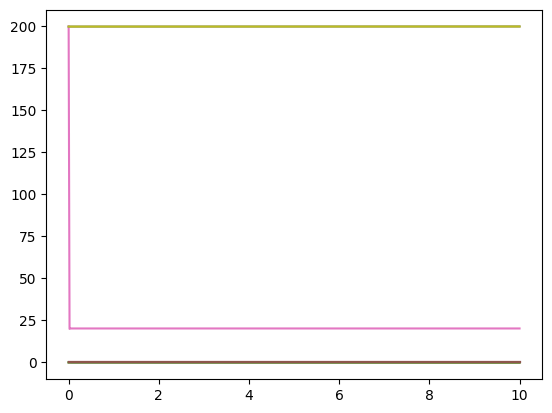

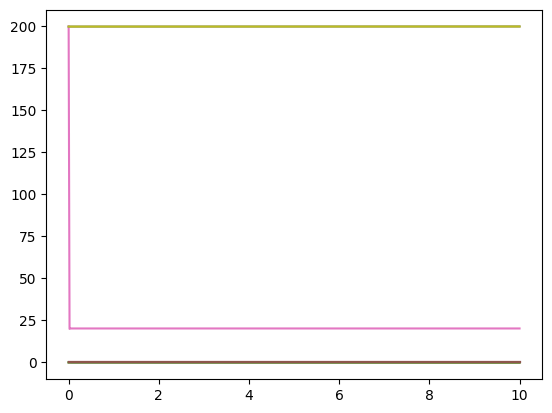

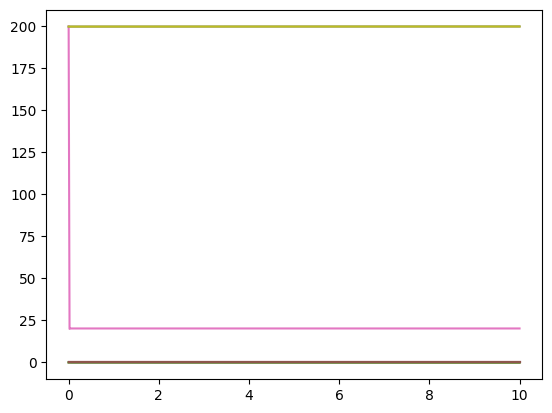

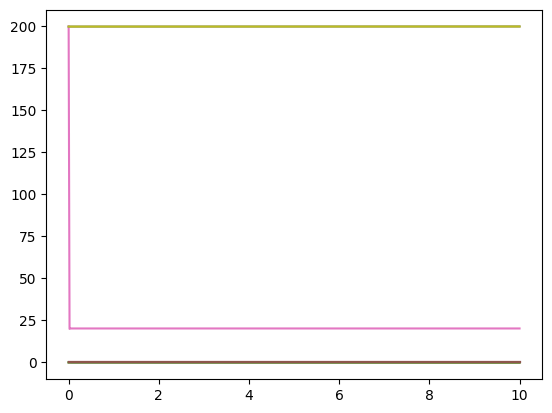

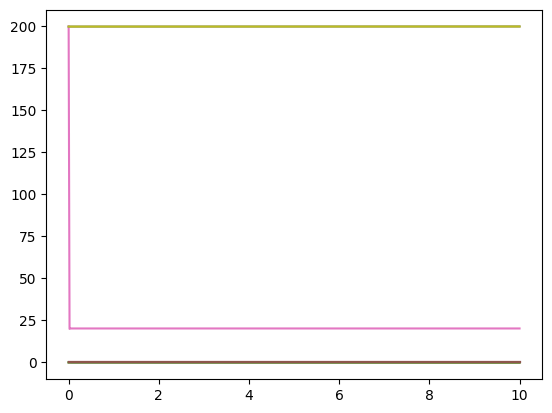

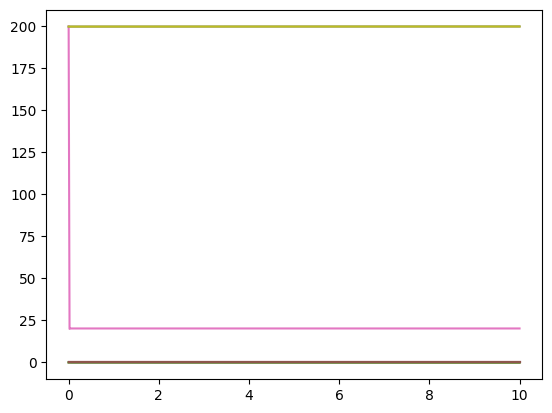

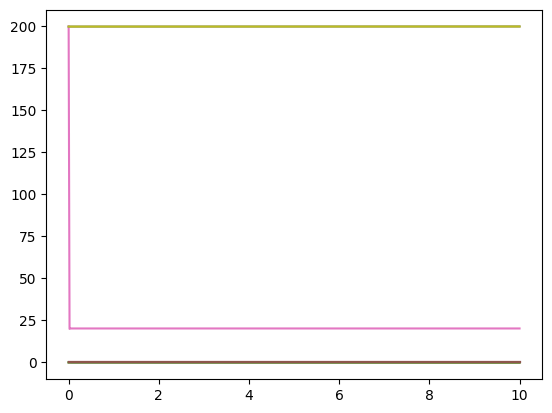

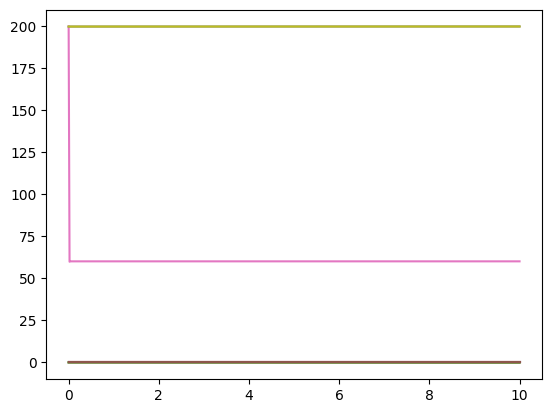

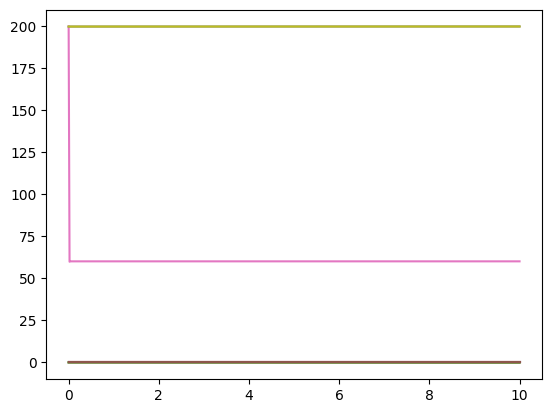

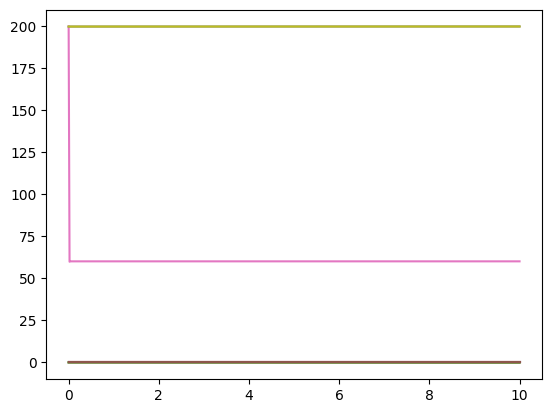

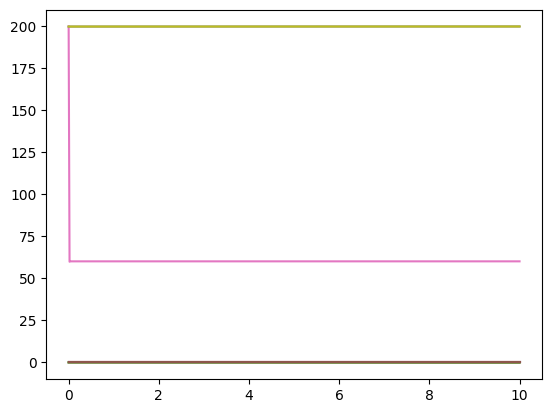

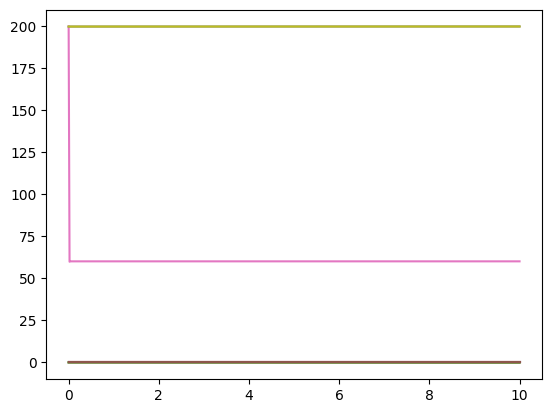

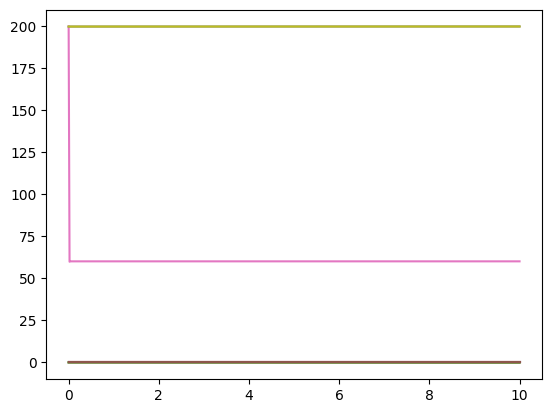

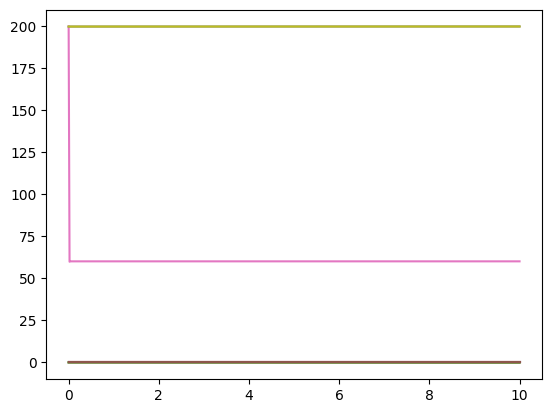

In [ ]:
# from synbio_morpher.utils.misc.type_handling import flatten_listlike
# for c in flatten_listlike(new_circuits):
#     plt.figure()
#     plt.plot(c.result_collector.results['signal'].vis_kwargs['t'], c.result_collector.results['signal'].data.T)